In [1]:
from torchvision import models, transforms
from torchsummary import summary
import torch
import numpy as np
import cv2
import PIL
import matplotlib.pyplot as plt

In [2]:
from utils import *

2024-11-20 21:51:07.553462: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-11-20 21:51:07.566949: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1732135867.583724  200319 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1732135867.587984  200319 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-11-20 21:51:07.604846: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instr

In [3]:
model = models.resnet50(pretrained=True)
#model = models.efficientnet_b0(pretrained=True)

/home/jakub/Documents/Tasks/final/grad-cam/.venv/lib/python3.12/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/jakub/Documents/Tasks/final/grad-cam/.venv/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [4]:
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
])

In [5]:
def get_image(path, transform):
    '''
    get image from path and transform it tensor
    '''
    img = PIL.Image.open(path)
    img_t = transform(img)
    print(img_t.shape)
    img_t = img_t.unsqueeze(0)
    return img_t
img = get_image('images/nosacz.jpg', transform)
img = get_image('images/bird.jpg', transform)
img = get_image('images/husky.jpg', transform)
type(img), img.shape

torch.Size([3, 224, 224])
torch.Size([3, 224, 224])
torch.Size([3, 224, 224])


(torch.Tensor, torch.Size([1, 3, 224, 224]))

In [6]:
target_layer = model.layer4[-1].conv3

activations = []
gradients = []

def forward_hook(module, input, output):
    activations.append(output)

def backward_hook(module, grad_in, grad_out):
    gradients.append(grad_out[0])

target_layer = model.layer4[-1].conv3
t1 = target_layer.register_forward_hook(forward_hook)
t2 = target_layer.register_full_backward_hook(backward_hook)

model.eval()
ouput = model(img)
pred_class = ouput.argmax().item()

model.zero_grad()
ouput[0, pred_class].backward()

gradients = gradients[0].cpu().data.numpy()
activations = activations[0].cpu().data.numpy()

t1.remove()
t2.remove()

weights = activations.mean(axis=(2, 3))

In [7]:
from utils import *
from src import *

In [8]:
imgg = get_image_torch('images/husky.jpg', 224, 224)
cam = get_cam(imgg, model, target_layer)

In [9]:
from utils import *

In [10]:
from pathlib import Path
path = Path('images/husky.jpg')

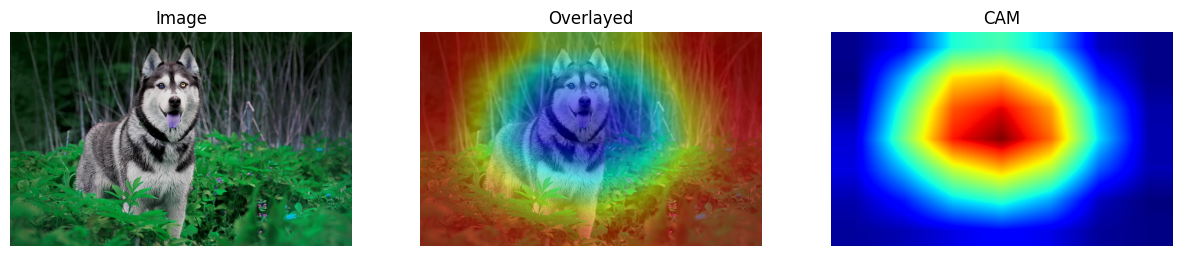

In [11]:
overlay_plot(path, cam, 0.5)

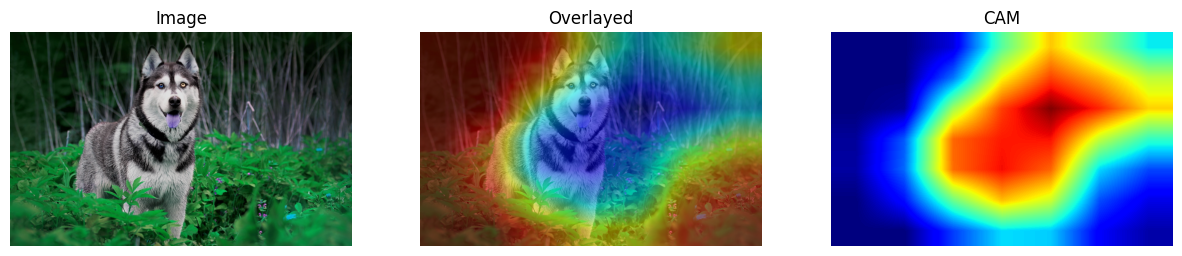

In [12]:
imgg = get_image_torch('images/bird.jpg', 224, 224)
grad_cam = get_gradcam(imgg, model, target_layer)

overlay_plot(path, grad_cam, 0.5)

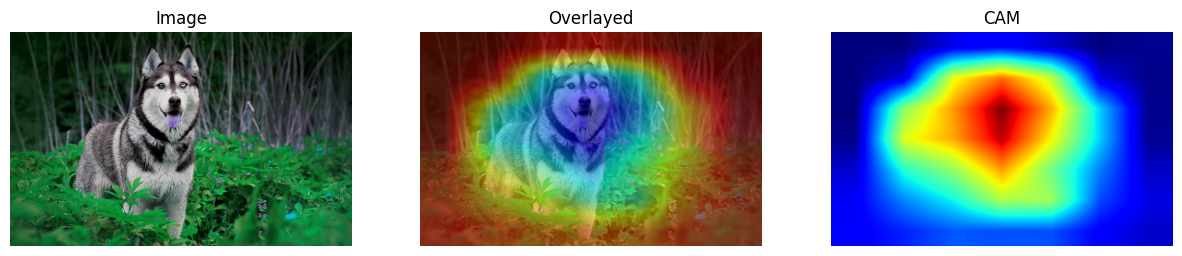

In [13]:
imgg = get_image_torch('images/nosacz.jpg', 224, 224)
hires_cam = get_hirescam(imgg, model, target_layer)

overlay_plot(path, hires_cam, 0.5)

In [14]:
cam = np.zeros(activations.shape[2:], dtype=np.float32)

for i, w in enumerate(weights[0]):
    cam += w * activations[0, i, :, :]

cam = np.maximum(cam, 0)

cam_temp = cam.copy()

heatmap = cv2.resize(cam, (224, 224))
heatmap = cv2.applyColorMap(np.uint8(255 * heatmap), cv2.COLORMAP_JET)
heatmap = np.float32(heatmap) / 255

heatmap_temp = heatmap.copy()

In [15]:
img = img.squeeze(0).permute(1, 2, 0).numpy()

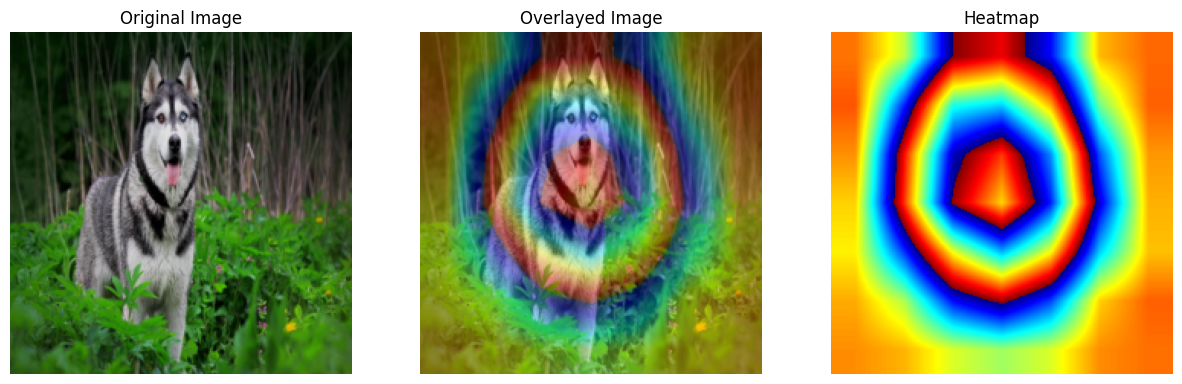

In [16]:
fig, axs = plt.subplots(1, 3, figsize=(15, 5))

axs[0].imshow(img)
axs[0].set_title('Original Image')
axs[0].axis('off')

axs[2].imshow(heatmap)
axs[2].set_title('Heatmap')
axs[2].axis('off')

overlayed_img = heatmap * 0.5 + img
overlayed_img = overlayed_img / overlayed_img.max()

axs[1].imshow(overlayed_img)
axs[1].set_title('Overlayed Image')
axs[1].axis('off')

plt.show()

2024-11-20 21:51:13.754232: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:152] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
Predicted class: ('n02109047', 'Great_Dane', 0.39497766)


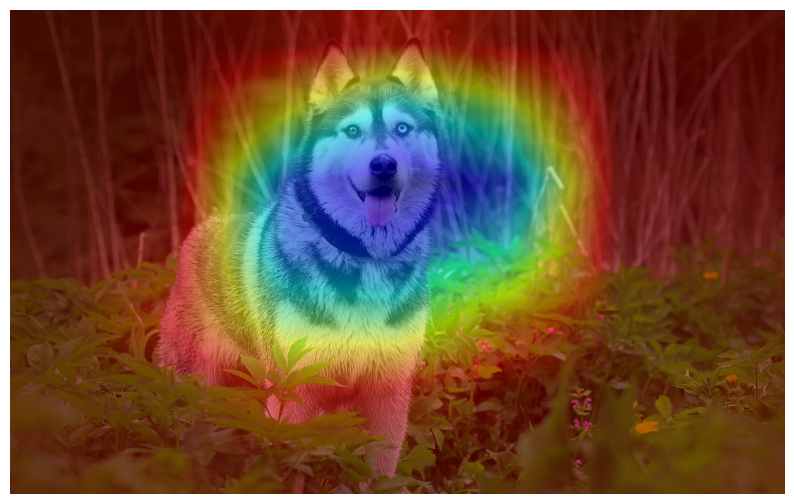

In [17]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.applications.resnet50 import preprocess_input, decode_predictions
from tensorflow.keras.preprocessing.image import load_img, img_to_array
import matplotlib.pyplot as plt

# Load Pretrained Model
model = ResNet50(weights='imagenet')

# Load and preprocess the image
def preprocess_image(image_path, target_size):
    img = load_img(image_path, target_size=target_size)
    img = img_to_array(img)
    img = np.expand_dims(img, axis=0)
    img = preprocess_input(img)
    return img

image_path = 'images/husky.jpg'  # Replace with your image path
preprocessed_image = preprocess_image(image_path, target_size=(224, 224))

# Predict the class
predictions = model.predict(preprocessed_image)
predicted_class = np.argmax(predictions[0])
decoded_prediction = decode_predictions(predictions, top=1)[0][0]
print(f"Predicted class: {decoded_prediction}")

# Generate CAM
def generate_cam(model, img_array, last_conv_layer_name, class_idx):
    # Get the output of the last convolutional layer and the output layer
    conv_layer = model.get_layer(last_conv_layer_name).output
    output_layer = model.output

    # Create a model that maps the input image to the activations of the conv layer and predictions
    cam_model = tf.keras.models.Model(inputs=model.input, outputs=[conv_layer, output_layer])

    # Get the weights of the class in the dense layer
    class_weights = model.layers[-1].weights[0][:, class_idx]

    # Extract conv layer output and predictions
    conv_outputs, predictions = cam_model(img_array)

    # Compute the weighted sum of the feature maps
    conv_outputs = conv_outputs[0]  # Shape: (7, 7, 2048)
    cam = np.dot(conv_outputs, class_weights)

    # Apply ReLU and normalize
    cam = np.maximum(cam, 0)
    cam = cam / np.max(cam)
    return cam

# Get the last conv layer name
last_conv_layer_name = "conv5_block3_out"  # For ResNet50

# Generate CAM
class_idx = predicted_class  # Index of the predicted class
cam = generate_cam(model, preprocessed_image, last_conv_layer_name, class_idx)

heatmap_temp2 = None

# Overlay CAM on the original image
def overlay_cam(cam, image_path, alpha=0.4):
    img = load_img(image_path)
    img = img_to_array(img)

    # Resize CAM to match the image size
    cam_resized = tf.image.resize(tf.expand_dims(cam, -1), (img.shape[0], img.shape[1])).numpy().squeeze()
    cam_resized = np.uint8(255 * cam_resized)
    heatmap = np.uint8(plt.cm.jet(cam_resized)[:, :, :3] * 255)
    heatmap_temp2 = heatmap.copy()

    # Superimpose CAM on the image
    superimposed_img = heatmap * alpha + img
    superimposed_img = np.clip(superimposed_img, 0, 255).astype("uint8")
    return superimposed_img


import cv2

def overlay_cam(cam, image_path, alpha=0.5):
    # Load the original image
    img = cv2.imread(image_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    # Resize CAM to match the image size
    cam_resized = cv2.resize(cam, (img.shape[1], img.shape[0]))  # Resize to (width, height)
    cam_resized = np.uint8(255 * cam_resized)  # Normalize to 0-255
    heatmap = cv2.applyColorMap(cam_resized, cv2.COLORMAP_JET)

    # Superimpose the heatmap on the original image
    superimposed_img = cv2.addWeighted(heatmap, alpha, img, 1 - alpha, 0)
    return superimposed_img



# Visualize the CAM
superimposed_img = overlay_cam(cam, image_path)

plt.figure(figsize=(10, 10))
plt.imshow(superimposed_img)
plt.axis("off")
plt.show()


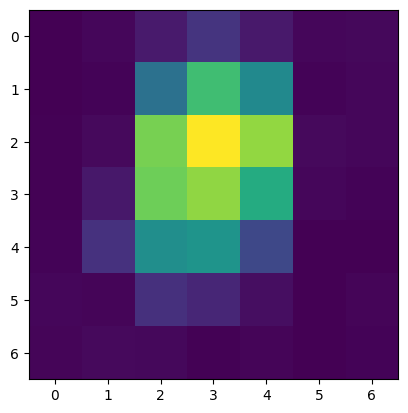

In [18]:
plt.imshow(cam)

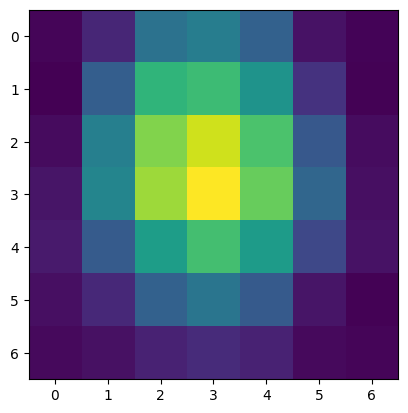

In [19]:
plt.imshow(cam_temp)

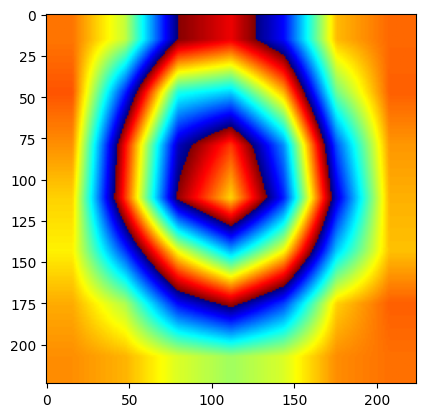

In [20]:
plt.imshow(heatmap)

In [21]:
heatmap_temp2

In [22]:
from utils import *